# Importing Libraries

In [1]:
import os
from dotenv import load_dotenv
from langchain_together import ChatTogether, TogetherEmbeddings
from langchain_community.vectorstores import Chroma

load_dotenv()

TOGETHER_API_KEY = os.getenv("TOGETHER_API_KEY")
together_model_name = "Qwen/Qwen3-235B-A22B-Instruct-2507-tput"
together_emb_model = "togethercomputer/m2-bert-80M-32k-retrieval"

embedding_function = TogetherEmbeddings(model=together_emb_model)

llm = ChatTogether(
    together_api_key=TOGETHER_API_KEY,
    model=together_model_name,
)

In [2]:
from langchain.document_loaders import TextLoader
loader = TextLoader(file_path=r"./car_inventory.txt")
docs = loader.load()

In [3]:
db = Chroma.from_documents(docs, embedding_function)
db

In [4]:
retriever = db.as_retriever(search_kwargs={"k": 2})
retriever

VectorStoreRetriever(tags=['Chroma', 'TogetherEmbeddings'], vectorstore=<langchain_community.vectorstores.chroma.Chroma object at 0x0000016F7FD35430>, search_kwargs={'k': 2})

In [5]:
user_input = "I want a car under $25K"
res = retriever.invoke(user_input)
res

[Document(metadata={'source': './car_inventory.txt'}, page_content='2023 Tesla Model 3 (Performance, used) is available at BMW of Fremont in New Jasonhaven, PR. It is a Coupe with Automatic transmission, runs on Hybrid, and has 32,594 miles. The MSRP is $34,371 with a discount of $500, bringing the final price to $33,871.\nFeatures include: 4WD/AWD, Auto Dimming Mirror, Remote Start.\nCurrent offers: GM Educator Offer ($-500); Purchase Allowance ($-500).\nVIN: N6R0D6K9D7M3W0V6U7M0L1A2G1W5K8 | Stock Number: BMW001.\nImage: https://example.com/images/tesla_model3.jpg\n\n2025 BMW X5 (xDrive40i, certified) is available at Concord Acura in Franciscoside, AZ. It is a Truck with Automatic transmission, runs on Electric, and has 27,298 miles. The MSRP is $32,958 with a discount of $2,000, bringing the final price to $30,958.\nFeatures include: Apple CarPlay, Lane Departure Warning, Bluetooth, 4WD/AWD.\nCurrent offers: Purchase Allowance for Current Eligible Non-GM Owners and Lessees ($-2,000).

# RAG Prompt

In [6]:
from langchain import hub
prompt = hub.pull("rlm/rag-prompt")
prompt

c:\sharath\Github\Projects\Loan prediction\loan-pred\.venv\Lib\site-packages\langsmith\client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


ChatPromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, metadata={'lc_hub_owner': 'rlm', 'lc_hub_repo': 'rag-prompt', 'lc_hub_commit_hash': '50442af133e61576e74536c6556cefe1fac147cad032f4377b60c436e6cdcb6e'}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:"), additional_kwargs={})])

In [7]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough


def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


rag_chain = prompt | llm
rag_chain

ChatPromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, metadata={'lc_hub_owner': 'rlm', 'lc_hub_repo': 'rag-prompt', 'lc_hub_commit_hash': '50442af133e61576e74536c6556cefe1fac147cad032f4377b60c436e6cdcb6e'}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:"), additional_kwargs={})])
| ChatTogether(client=<openai.resources.chat.completions.completions.Completions object at 0x0000016F7FDD50D0>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x0000016F7FDD5790>, root_client=<openai.OpenAI object at 0x0000016F7FD0D070>, root_

# State

In [17]:
from typing import Annotated, Literal, TypedDict, Optional
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langchain.schema import Document

from pydantic import BaseModel, Field

class AgentState(BaseModel):
    messages: list[BaseMessage]
    documents: Optional[list[Document]] = None
    on_topic: Optional[str] = None

# Defining functions

In [27]:
from langchain_core.prompts import ChatPromptTemplate

class GradeQuestion(BaseModel):
    """
    Boolean value to check weather a question is related to the Cars
    """

    score: str = Field(
        description="Question is about Cars? If yes -> 'Yes' if not 'No'"
    )

def question_classifier(state: AgentState):
    question = state.messages[-1].content

    system = """
    You are a classifier that determines whether a user's question is about one of the following topics:
    1. Information about Cars
    2. Prices of the Cars
    3. Features of the Cars
    4. Offers of the Cars

    If the question is about any of these topics, respond with 'Yes'. Otherwise, respond with 'No'.
    Remember, Only YES or NO, nothing else in the response!
    """

    grade_prompt = ChatPromptTemplate.from_messages(
        [
            ('system', system),
            ('human', "User question: {question}")
        ]
    )

    structured_llm = llm.with_structured_output(GradeQuestion)
    grader_llm = grade_prompt | structured_llm
    result = grader_llm.invoke({'question': question})
    print(f"RESULT: {result}")
    state.on_topic = result.score
    return state

def on_topic_router(state: AgentState):
    on_topic = state.on_topic
    if on_topic.lower() == "yes":
        return "on_topic"
    return "off_topic"

def retrieve(state: AgentState):
    question = state.messages[-1].content
    documents = retriever.invoke(question)
    state.documents = documents
    return state

def generate_answer(state: AgentState):
    question = state.messages[-1].content
    documents = state.documents
    generation = rag_chain.invoke(
        {
            "context": documents,
            "question": question
        }
    )
    state.messages.append(generation)
    return state

def off_topic_response(state: AgentState):
    state.messages.append(AIMessage(content="I cant response to that!"))
    return state

# Defining Graph

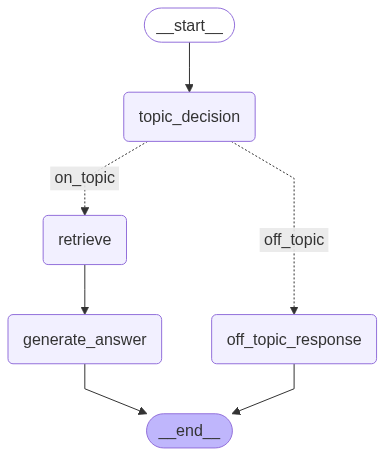

In [28]:
from langgraph.graph import StateGraph, END

workflow = StateGraph(AgentState)

workflow.add_node("topic_decision", question_classifier)
workflow.add_node("off_topic_response", off_topic_response)
workflow.add_node("retrieve", retrieve)
workflow.add_node("generate_answer", generate_answer)


workflow.add_conditional_edges(
    "topic_decision",
    on_topic_router,
    {
        "on_topic": "retrieve",
        "off_topic": "off_topic_response"
    },
)


workflow.add_edge("retrieve", "generate_answer")
workflow.add_edge("generate_answer", END)
workflow.add_edge("off_topic_response", END)


workflow.set_entry_point("topic_decision")
graph = workflow.compile()

graph

In [32]:
messages1 = [HumanMessage(content="I want a car under $25K")]
messages2 = [HumanMessage(content="List me the cars with best features and good discount under 50K")]
messages3 = [HumanMessage(content="Who is Sharath")]

In [30]:
res1 = graph.invoke(
    input={
        "messages": messages1
    }
)
res1

RESULT: score='Yes'


{'messages': [HumanMessage(content='I want a car under $25K', additional_kwargs={}, response_metadata={}),
  AIMessage(content='You can consider the 2025 Ford Mustang (EcoBoost, new) at Bay Area Honda in Brianhaven, NY, priced at $29,350 after a $3,000 discount. Another option is the 2024 Tesla Model 3 (Standard, certified) at Ford Sunnyvale in Jonhaven, AR, priced at $24,281 after a $5,000 discount. Both are under $25,000 after discounts.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 108, 'prompt_tokens': 97999, 'total_tokens': 98107, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'Qwen/Qwen3-235B-A22B-Instruct-2507-tput', 'system_fingerprint': None, 'id': 'o8Pzo9b-zqrih-974091a56b50999b', 'service_tier': None, 'finish_reason': 'stop', 'logprobs': None}, id='run--1e85b77e-2eba-41b7-935f-70e9d985a7d7-0', usage_metadata={'input_tokens': 97999, 'output_tokens': 108, 'total_tokens': 98107, 'input_token_deta

In [31]:
res2 = graph.invoke(
    input={
        "messages": messages2
    }
)
res2

RESULT: score='Yes'


{'messages': [HumanMessage(content='List me the cars with best features and good discount under 50K', additional_kwargs={}, response_metadata={}),
  AIMessage(content='The 2025 BMW X5 (xDrive40i, certified) is available for $31,488 with a $5,000 discount and features like adaptive cruise control, cooled seats, and remote start. The 2024 Acura Integra (A-Spec Tech Package, certified) is priced at $29,811 with a $5,000 discount and includes cooled seats, 4WD/AWD, and adaptive cruise control. Both are under $50,000 and offer strong features with significant discounts.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 124, 'prompt_tokens': 98005, 'total_tokens': 98129, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'Qwen/Qwen3-235B-A22B-Instruct-2507-tput', 'system_fingerprint': None, 'id': 'o8Q17xS-28Eivz-9740933528dab22e', 'service_tier': None, 'finish_reason': 'stop', 'logprobs': None}, id='run--f6801066-69a0

In [33]:
res3 = graph.invoke(
    input={
        "messages": messages3
    }
)
res3

RESULT: score='No'


{'messages': [HumanMessage(content='Who is Sharath', additional_kwargs={}, response_metadata={}),
  AIMessage(content='I cant response to that!', additional_kwargs={}, response_metadata={})],
 'on_topic': 'No'}

# Retrieval with Tools

In [34]:
from langchain.tools.retriever import create_retriever_tool
from langchain_core.tools import tool

retriever_tool = create_retriever_tool(
    retriever,
    "retriever_tool",
    "Information related to pricing, discount and features of the cars."
)

@tool
def off_topic():
    """Catch all Questions not related to pricing, discount, features of the cars"""
    return "Forbidden - do not respond to the user."

tools = [retriever_tool, off_topic]

## Sequence

- In Python's type hinting system, Sequence from the typing module represents a type hint for any object that behaves like a sequence, meaning it supports iteration and indexing. This includes built-in types such as list, tuple, str, and bytes.
- When you use from typing import Sequence, you are importing this specific type hint to use in your function signatures or variable annotations. This allows you to specify that a parameter or variable is expected to be a sequence, without restricting it to a particular concrete sequence type like list or tuple.

In [35]:
from typing import Sequence

from langgraph.graph.message import add_messages

class AgentStatev2(BaseModel):
    messages: Annotated[Sequence[BaseMessage], add_messages]


def agent(state: AgentStatev2):
    messages = state.messages
    model = llm.bind_tools(tools)
    response = model.invoke(messages)
    return {"messages": [response]}

def should_continue(state: AgentStatev2) -> Literal["tools", END]:
    messages = state.messages
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return END


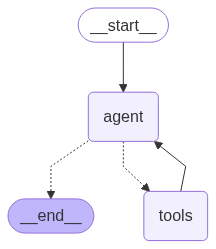

In [36]:
from langgraph.graph import START, END, StateGraph
from langgraph.prebuilt import ToolNode

workflow_v2 = StateGraph(AgentStatev2)

workflow_v2.add_node("agent", agent)

tool_node = ToolNode(tools)

workflow_v2.add_node("tools", tool_node)

workflow_v2.add_edge(START, "agent")
workflow_v2.add_conditional_edges(
    "agent",
    should_continue,
)
workflow_v2.add_edge("tools", "agent")
graph_v2 = workflow_v2.compile()
graph_v2

In [37]:
res1 = graph_v2.invoke(
    input={
        "messages": messages1
    }
)
res1

{'messages': [HumanMessage(content='I want a car under $25K', additional_kwargs={}, response_metadata={}, id='a26b143b-f553-4f05-8bfe-c4966ecd2ba8'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_xvt19ny1w2jlcm2nnl9boa59', 'function': {'arguments': '{"query":"cars under $25,000"}', 'name': 'retriever_tool'}, 'type': 'function', 'index': 0}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 30, 'prompt_tokens': 223, 'total_tokens': 253, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'Qwen/Qwen3-235B-A22B-Instruct-2507-tput', 'system_fingerprint': None, 'id': 'o8Q7SPU-28Eivz-9740b14b1b3bc7cf', 'service_tier': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--5ea21f35-7981-49e8-ae04-e772f2661beb-0', tool_calls=[{'name': 'retriever_tool', 'args': {'query': 'cars under $25,000'}, 'id': 'call_xvt19ny1w2jlcm2nnl9boa59', 'type': 'tool_call'}], usage_metadata={'input_tokens': 223, 'output_tokens':

In [38]:
res2 = graph_v2.invoke(
    input={
        "messages": messages2
    }
)
res2

{'messages': [HumanMessage(content='List me the cars with best features and good discount under 50K', additional_kwargs={}, response_metadata={}, id='8470d48c-73cc-41bc-b7ef-288f71765271'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_2v6e2jiuj7t9wmfjlcei2vt0', 'function': {'arguments': '{"query":"cars with best features and good discount under 50K"}', 'name': 'retriever_tool'}, 'type': 'function', 'index': 0}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 33, 'prompt_tokens': 229, 'total_tokens': 262, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'Qwen/Qwen3-235B-A22B-Instruct-2507-tput', 'system_fingerprint': None, 'id': 'o8Q7aru-zqrih-9740b1fe2918c7cf', 'service_tier': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--cd2be1d6-b4e9-4e6d-89a6-cc5aa21d5a50-0', tool_calls=[{'name': 'retriever_tool', 'args': {'query': 'cars with best features and good discount under 50K'}, 'id': 'cal

In [39]:
res3 = graph_v2.invoke(
    input={
        "messages": messages3
    }
)
res3

{'messages': [HumanMessage(content='Who is Sharath', additional_kwargs={}, response_metadata={}, id='57d9749b-bc5c-4e2a-befb-59f598cee44a'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_u5qug19vwvz068gut07aszir', 'function': {'arguments': '{}', 'name': 'off_topic'}, 'type': 'function', 'index': 0}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 218, 'total_tokens': 234, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'Qwen/Qwen3-235B-A22B-Instruct-2507-tput', 'system_fingerprint': None, 'id': 'o8Q7oAo-28Eivz-9740b3026df0c7cf', 'service_tier': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--66b60f5e-0c5d-402f-8848-05d0b79b5e68-0', tool_calls=[{'name': 'off_topic', 'args': {}, 'id': 'call_u5qug19vwvz068gut07aszir', 'type': 'tool_call'}], usage_metadata={'input_tokens': 218, 'output_tokens': 16, 'total_tokens': 234, 'input_token_details': {}, 'output_token_details':